In [2]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from getdist import plots
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.samplers.emcee import EmceeSampler
from desilike.samplers import ZeusSampler
from desilike.samples import plotting, Chain
# from desilike import setup_logging
# setup_logging()  # for logging messages

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# the tracers for DESI mocks
tracers = {
    'ELG_lowz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 0.8,
        'zmax': 1.1,
        'zeff': 0.98,
        'ran_mock_num': '10'
    },
    'ELG_highz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 1.1,
        'zmax': 1.6,
        'zeff': 1.325,
        'ran_mock_num': '10'
    },
}

In [4]:
MOCKNUM = 0
survey  ='Y1'
specver ='iron'
mockver ='v4_2'
tracer_type = 'ELG_lowz' # 'ELG_lowz', 'ELG_highz', 
region = "GCcomb"  # NGC, SGC or GCcomb

if tracer_type in tracers:
    settings = tracers[tracer_type]
    tracer = settings['tracer']
    zmin = settings['zmin']
    zmax = settings['zmax']
    zeff = settings['zeff']
    ran_mock_num = settings['ran_mock_num']
else:
    raise ValueError(f"Unknown ztype: {tracer_type}")

pk_dir = f'/pscratch/sd/s/shengyu/statistics/{tracer}/pk/'
cov_dir = f'/global/cfs/cdirs/desi/survey/catalogs/{survey}/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'
mock_dir = f'/pscratch/sd/s/shengyu/mocks/{survey}/Abacus_{mockver}/altmtl{MOCKNUM}/{specver}/mock{MOCKNUM}/LSScats/'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(0, 1000):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [6]:
# set the k bins
kmin     = 0.020
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC

catas_types = ['','_realistic', '_failures']
catas_type = '_failures'

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05{catas_type}.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05{catas_type}.npy'

In [7]:
# MCMC sampling
nwalkers = 64 
interations = 6001 # save every 300 iterations

emulator_fn = f'./results/emulators/emulator_{cosmology}_z{zeff}_{theory_model}.npy'
chain_fn = f'./results/samples/{cosmology}/chain_{tracer}_{region}_z{zeff}{catas_type}.npy'

if os.path.exists(chain_fn):
    os.remove(chain_fn)
if not os.path.exists(chain_fn):
    if theory_model == 'FOLPS':
        theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
    if theory_model == 'FOLPSRC':
        theory_el = FOLPSRCTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))  
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)                    
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    sampler = EmceeSampler(likelihood, seed=40, nwalkers=nwalkers, save_fn =chain_fn)
    # sampler = ZeusSampler(likelihood, seed=42, nwalkers=nwalkers, save_fn =chain_fn)
    sampler.run(check={'max_eigen_gr': 0.1}, max_iterations = interations) # save every 300 iterations
    print("Sampling finished")

NameError: name 'FOLPSTracerPowerSpectrumMultipoles' is not defined

In [42]:
chain = Chain.load(chain_fn).remove_burnin()[::]
print(chain.to_stats(tablefmt='pretty'))
print(chain.logposterior[-1,-5:])

[000192.06] [0/1] 11-07 08:32  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98_failures.npy.
+-----------+---------+---------+---------+--------+-----------------+-----------------+
|           | argmax  |  mean   | median  |  std   | quantile:1sigma | interval:1sigma |
+-----------+---------+---------+---------+--------+-----------------+-----------------+
|     h     |  0.666  |  0.686  |  0.686  | 0.029  |  -0.027/+0.028  |  -0.031/+0.023  |
| omega_cdm |  0.110  |  0.118  |  0.117  | 0.012  |  -0.012/+0.012  |  -0.013/+0.011  |
|  omega_b  | 0.02220 | 0.02241 | 0.02240 | 4.0e-4 | -4.0e-4/+4.0e-4 | -4.3e-4/+3.7e-4 |
|   logA    |  3.16   |  3.03   |  3.03   |  0.15  |   -0.15/+0.15   |   -0.14/+0.16   |
|    b1     |  1.15   |  1.21   |  1.20   |  0.12  |   -0.12/+0.12   |   -0.13/+0.11   |
|    b2     |  -2.0   |  -0.6   |  -0.6   |  1.5   |    -1.6/+1.6    |    -1.6/+1.5    |
|    bs     |   3.6   |   1.2   |   1.0   |  3.2   |   

[000193.92] [0/1] 11-07 08:32  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98_failures.npy.


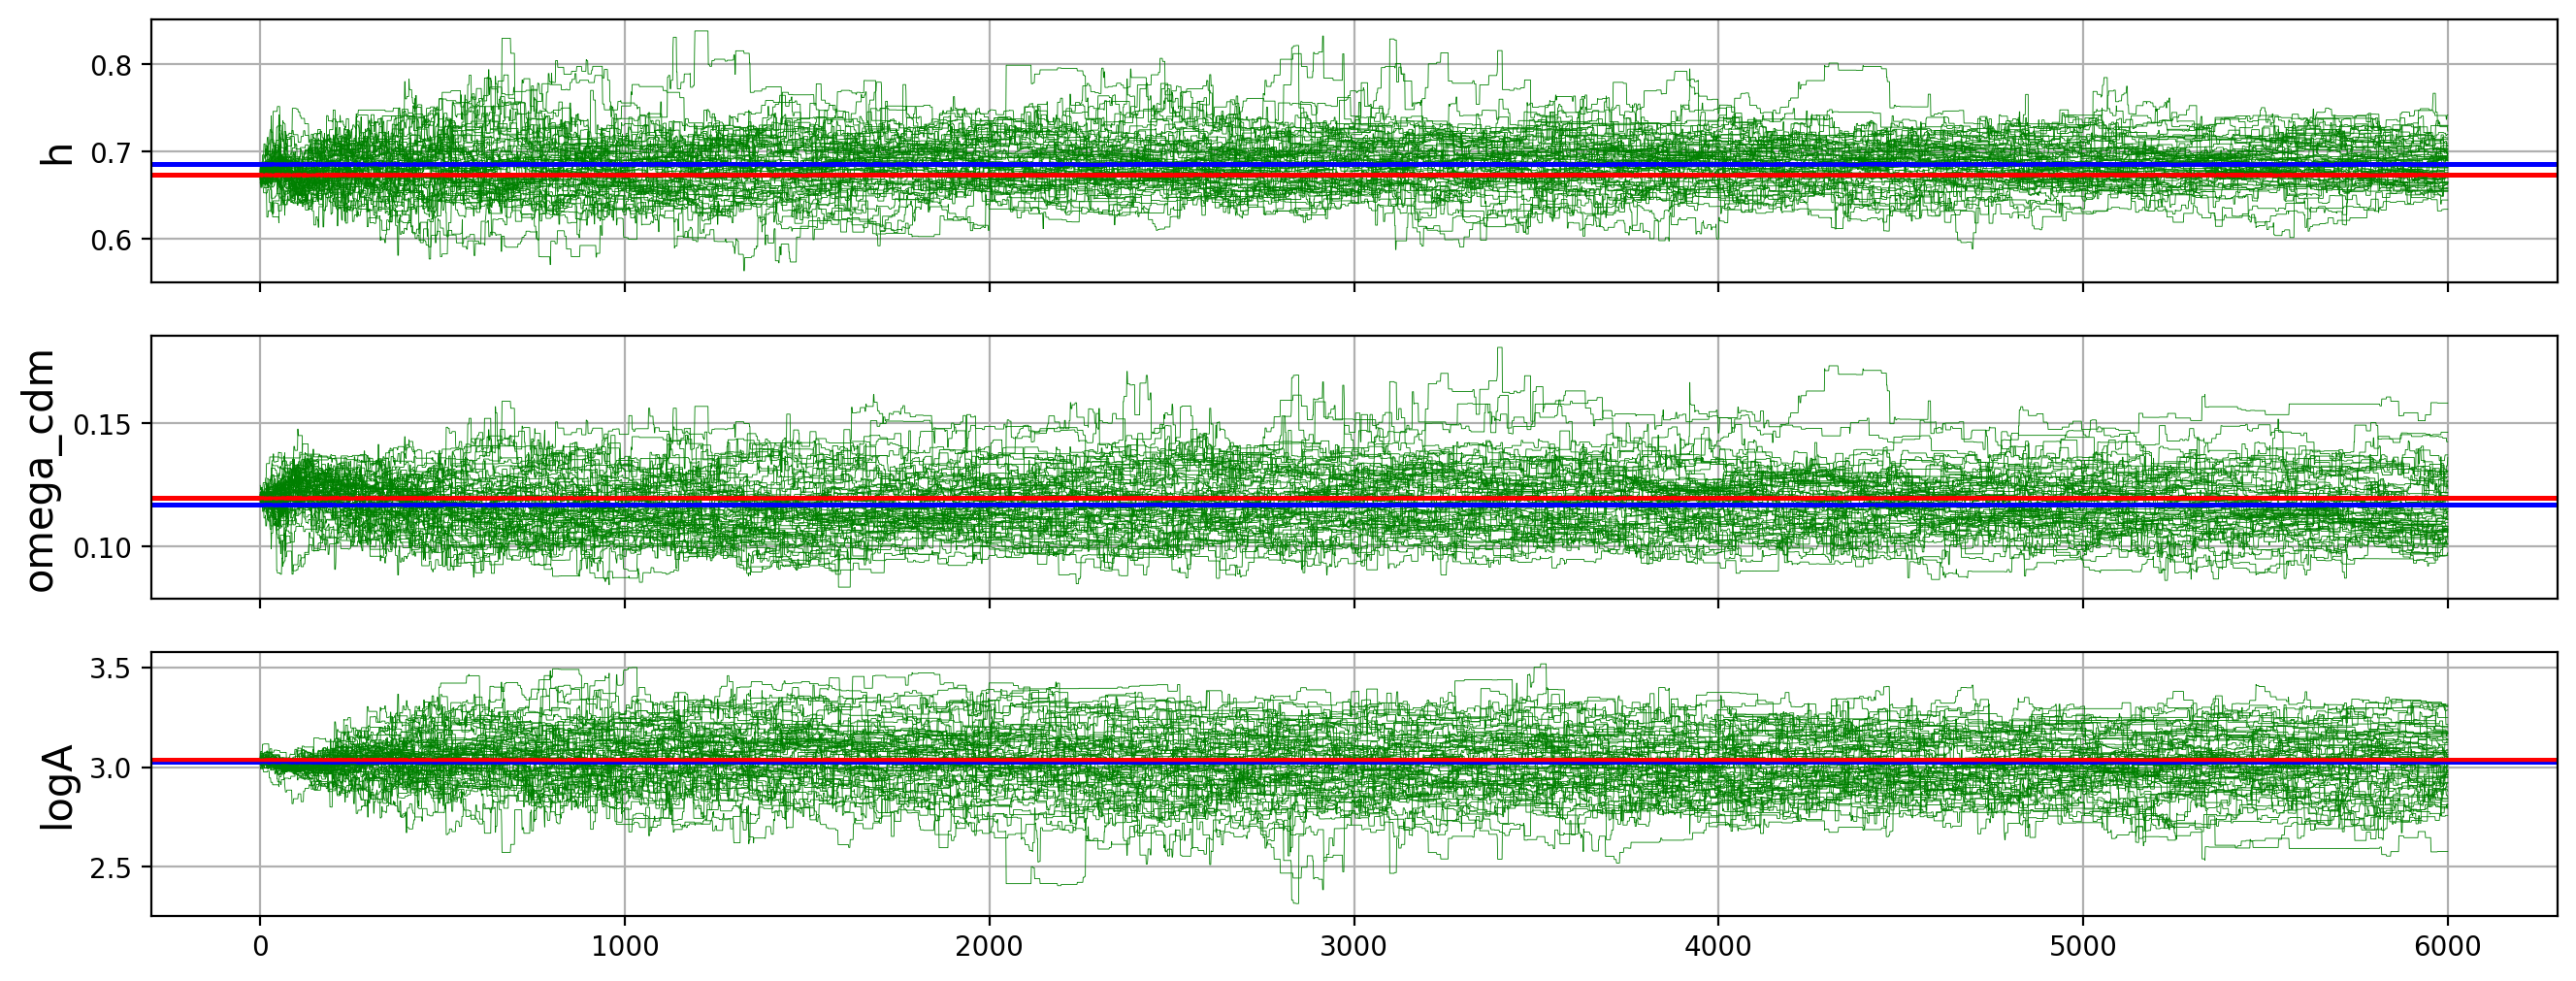

In [ ]:
def set_true_values(params, catalogue='LCDM'):
    # true values for the AbacusSummit simulation
    update_values = {
        'LCDM': {'h':0.6736, 'omega_cdm': 0.1200, 'Omega_cdm': 0.2685, 'omega_b':0.02207,'logA': 3.0364, 'm_ncdm': 0.0, 'n_s':0.9624, 'w0_fld':-1.0, 'fc':0.01},
    }
    if catalogue in update_values:
        truth_values = update_values[catalogue]
    return [truth_values[param] for param in params if param in truth_values]

params= ['h', 'omega_cdm', 'logA']
ndim            = len(params)
chain = Chain.load(chain_fn).remove_burnin()[::]
chain_samples   = dict(zip(chain.basenames(), chain.data))
samples         = np.array([chain_samples[p] for p in params])
medians         = np.array(chain.median(params=params))
true_values     = set_true_values(params)

fig, ax = plt.subplots(ndim, sharex=True, figsize=(16, 2 * ndim))
for i in range(nwalkers):
    for j in range(ndim):
        ax[j].plot(samples[j, :, i], c = 'green', lw=0.3)
        ax[j].set_ylabel(params[j], fontsize=15)
        ax[j].grid(True)
        ax[j].axhline(medians[j], c='blue', lw=1.2)
        ax[j].axhline(true_values[j], c='red', lw=1.2)

[000441.54] [0/1] 11-07 08:36  Chain                     INFO     Loading ./results/samples/LCDM/chain_ELG_LOPnotqso_GCcomb_z0.98.npy.
Removed no burn in


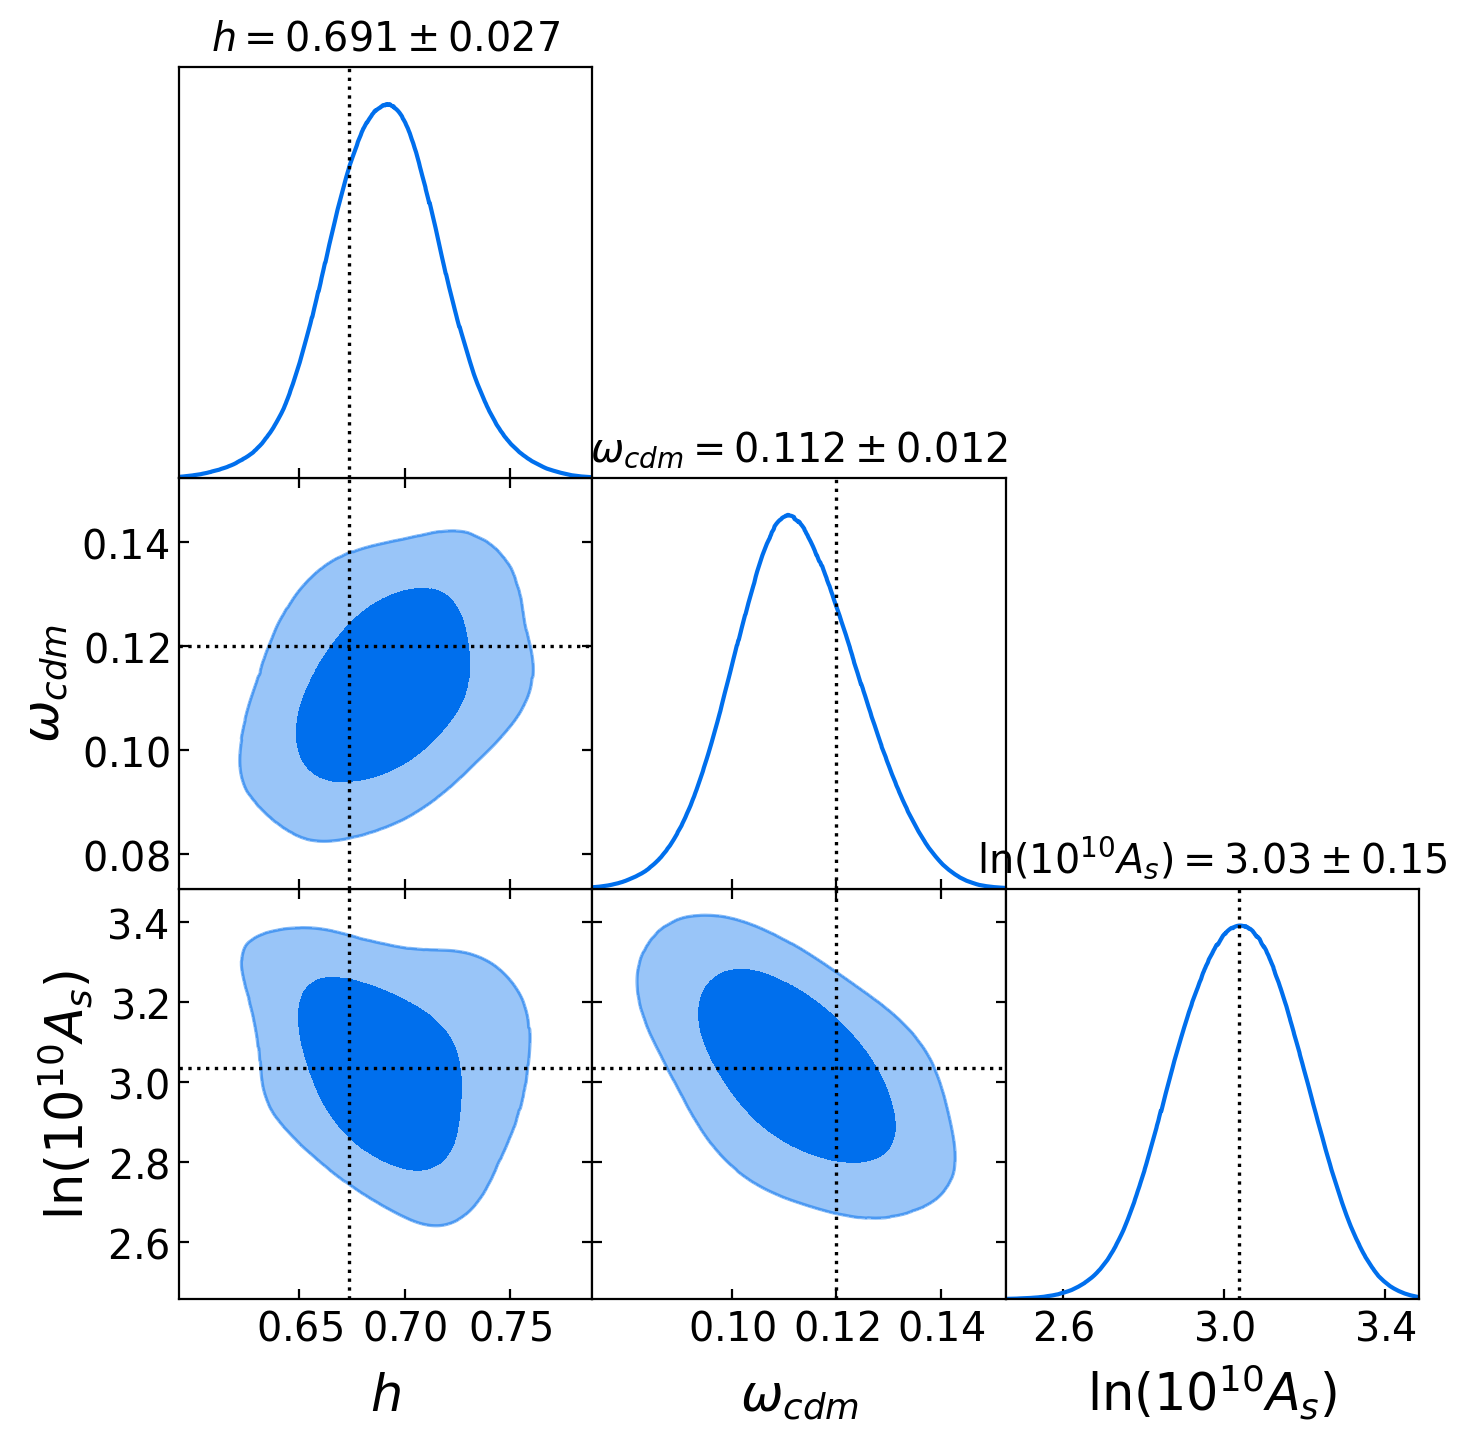

In [52]:
# plot the corner plot for posterior distributions
burnin      = 0.60
slice_step  = 1000
params = ['h','omega_cdm','logA']

catas_type = ''
chain_fn = f'./results/samples/{cosmology}/chain_{tracer}_{region}_z{zeff}{catas_type}.npy'

chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]

g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.axes_fontsize = 16
g.settings.figure_legend_frame = False

plotting.plot_triangle(chain, title_limit=1, filled = True, params = params,
                        #    legend_labels = [r'$FOLPS+f_c$', r'$FOLPS$'], legend_loc= 'upper right',
                            contour_lws = 1.5,
                            # contour_ls = lss, contour_lws = lws, contour_colors = colors, 
                            # param_limits=param_limits, 
                            smoothed=True, show=False, g=g)
true_values     = set_true_values(params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)